In [1]:
import dynamo as dyn
dyn.get_all_dependencies_version()

package,seaborn,pandas,numpy,numba,networkx,matplotlib,igraph,dynamo-release,anndata,session-info,setuptools,umap-learn,typing-extensions,tqdm,statsmodels,scipy,scikit-learn,pynndescent,pre-commit,openpyxl,numdifftools,loompy,get-version,colorcet
version,0.12.2,1.5.3,1.23.5,0.58.1,3.1,3.6.3,0.10.8,1.4.0,0.9.2,1.0.0,67.6.0,0.5.5,4.9.0,4.66.1,0.14.1,1.10.1,1.3.2,0.5.11,3.5.0,3.1.2,0.9.41,3.0.7,3.5.4,3.0.1


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import anndata as ad
import dynamo as dyn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import omicverse as ov
import scanpy as sc


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/


# load raw h5ad form dynast result

In [ ]:
No2 = dyn.read_h5ad('01.dynast/4_estimate/mCPBA5.2/adata.h5ad')
No3 = dyn.read_h5ad('01.dynast/4_estimate/mCPBA7.4/adata.h5ad')
iaa = dyn.read_h5ad('01.dynast/4_estimate/5.5hpf-IAA/adata.h5ad')
ctrl = dyn.read_h5ad('01.dynast/2_count/adata.h5ad')

In [ ]:
No2.obs['batch'] = '5.5hpf-mCPBApH5.2'
No3.obs['batch'] = '5.5hpf-mCPBApH7.4'
iaa.obs['batch'] = '5.5hpf-IAA'
ctrl.obs['batch'] = '5.5hpf-Ctrl'
No2.obs_names = [f'5.5hpf-mCPBApH5.2-' + x for x in No2.obs_names]
No3.obs_names = [f'5.5hpf-mCPBApH7.4-' + x for x in No3.obs_names]
iaa.obs_names = [f'5.5hpf-IAA-' + x for x in iaa.obs_names]
ctrl.obs_names = [f'5.5hpf-Ctrl-' + x for x in ctrl.obs_names]

In [ ]:
adata_list = {}
adata_list['5.5hpf-mCPBApH5.2']=No2
adata_list['5.5hpf-mCPBApH7.4']=No3
adata_list['5.5hpf-IAA']=iaa
adata_list['5.5hpf-Ctrl']=ctrl

In [ ]:
#merge adata
ad_all =ad.concat(adata_list,join='outer')

# process

In [ ]:
ad_all=ov.pp.qc(ad_all,
              tresh={'mito_perc': 0.1, 'nUMIs': 800, 'detected_genes': 400},mt_startswith='mt-',)

In [ ]:
adata = ad_all.copy()

In [ ]:
# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata,target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Identify hignly-variable genes
sc.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3,min_disp=0.5)

In [ ]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression 
# for later use in differential testing and visualizations of gene expression.
adata.raw = adata
# Retain highly variable genes.
adata = adata[:,adata.var.highly_variable]
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['nUMIs', 'mito_perc'])
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [ ]:
# Reduce the dimensionality of the data by running PCA
sc.tl.pca(adata, svd_solver='arpack',n_comps=30)

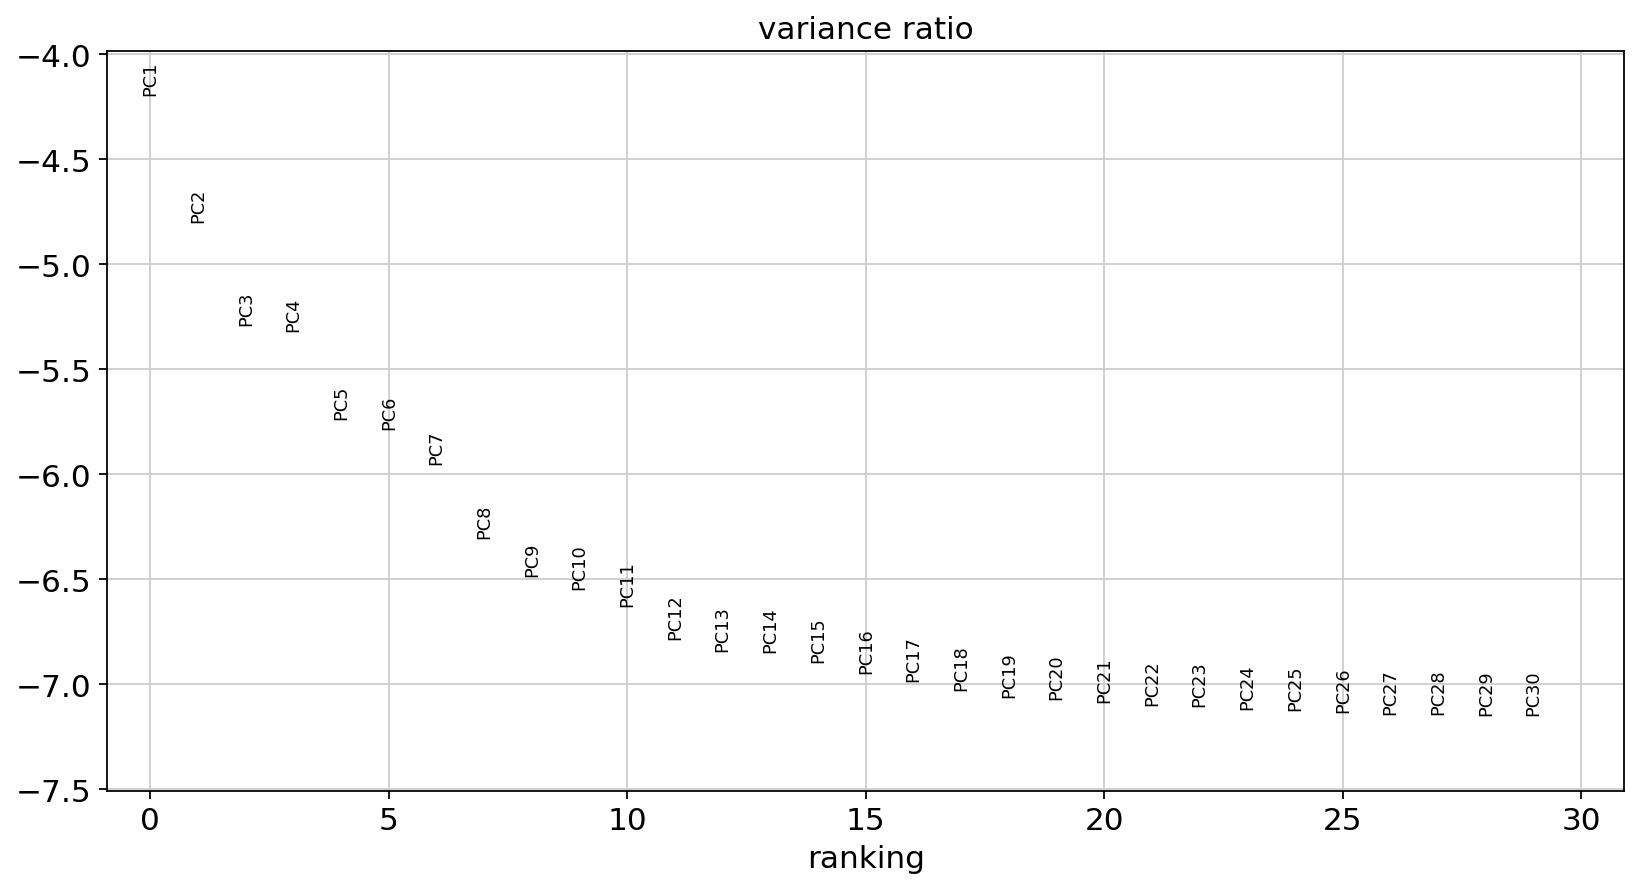

In [5]:
sc.set_figure_params(dpi=80, dpi_save=150,figsize=(12,6))
sc.pl.pca_variance_ratio(adata,log=True,n_pcs=30)

In [ ]:
# Compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16,use_rep='X_pca')

In [ ]:
# Embed the neighborhood graph using UMAP
sc.tl.umap(adata)

In [33]:
os.chdir('/home/mingjian/workbase/04_chemical.methods/07.code_submit/data')

In [ ]:
adata.write_h5ad('./Fig3_data/Fig3_Dropseq_3methods_noHarmony.h5ad',compression='gzip')

In [4]:
adata = sc.read_h5ad('./Fig3_data/Fig3_Dropseq_3methods_noHarmony.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 9883 × 3520
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'batch', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'mt', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'layers_counts', 'log1p', 'neighbors', 'pca', 'scrublet', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'rates', 'rates_X', 'rates_spliced', 'rates_unspliced'
    varm: 'PCs'
    layers: 'X_l_TC', 'X_l_TC_est', 'X_n_TC', 'X_n_TC_est', 'ambiguous', 'labeled_TC', 'labeled_TC_est', 'sl_TC', 'sl_TC_est', 'sn_TC', 'sn_TC_est', 'spliced', 'total', 'ul_TC', 'ul_TC_est', 'un_TC', 'un_TC_est', 'unlabeled_TC', 'unlabeled_TC_est', 'unspliced'
    obsp: 'connectivities', 'distances'

In [11]:
adata.uns['sample_colors'] = [ '#D7D9DB', '#D1261B', '#2E6FAC','#32A02C']

In [12]:
adata.obs['sample'] = adata.obs['batch']

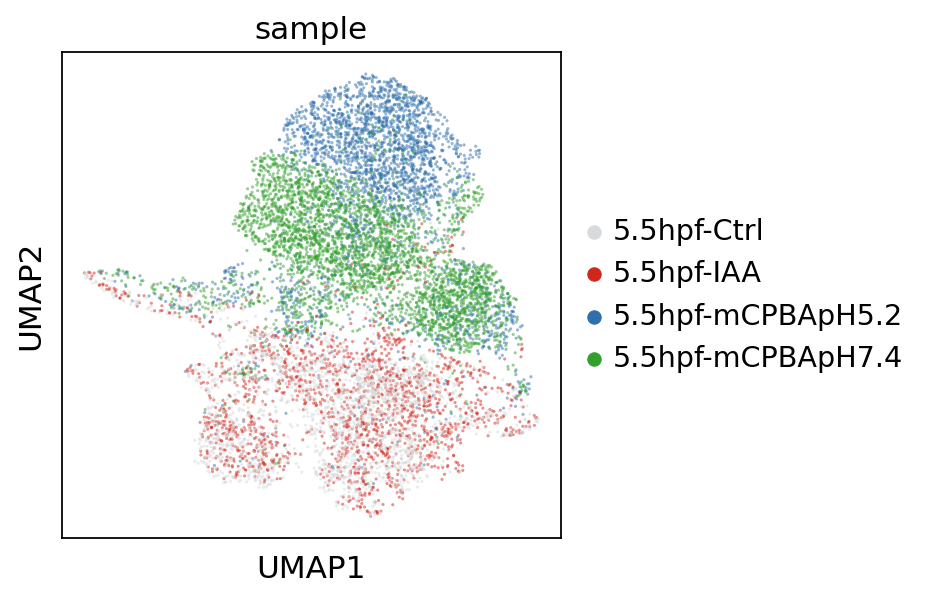

In [13]:
sc.set_figure_params(dpi=80, dpi_save=150,figsize=(4,4))
sc.pl.umap(adata,color='sample',size=8,alpha=0.5)

## harmony integrate

In [14]:
import scanpy.external as sce

In [15]:
sce.pp.harmony_integrate(adata, 'sample')

2024-08-20 15:52:00,630 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-20 15:52:03,196 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-20 15:52:03,247 - harmonypy - INFO - Iteration 1 of 10
2024-08-20 15:52:05,321 - harmonypy - INFO - Iteration 2 of 10
2024-08-20 15:52:07,381 - harmonypy - INFO - Converged after 2 iterations


In [16]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=16)
sc.tl.umap(adata)

In [24]:
adata.obs['sample'].value_counts()

5.5hpf-mCPBApH7.4    3456
5.5hpf-mCPBApH5.2    2731
5.5hpf-Ctrl          1997
5.5hpf-IAA           1699
Name: sample, dtype: int64

# Fig3C

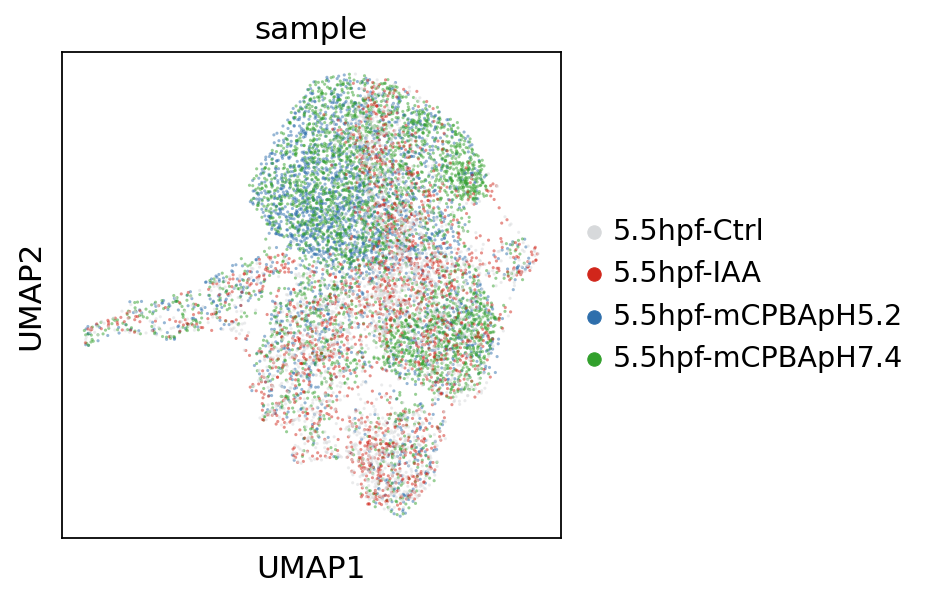

In [17]:
sc.set_figure_params(dpi=80, dpi_save=150,figsize=(4,4))
sc.pl.umap(adata,color='sample',size=8,alpha=0.5)

# Clustering the neighborhood graph

In [18]:
sc.tl.leiden(adata,resolution=.2)
adata.obs['res_.2'] = adata.obs['leiden']
sc.tl.leiden(adata,resolution=.4)
adata.obs['res_.4'] = adata.obs['leiden']

In [19]:
# Compute a ranking for the highly differenetial genes in each cluster.
sc.tl.rank_genes_groups(adata,'res_.4',method='wilcoxon')

In [20]:
results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names
pd.set_option('display.max_columns',50)
genedf = pd.DataFrame(
    {group + '_' + key[:1]:results[key][group]
    for group in groups for key in ['names','pvals']})
genedf.head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p
0,nnr,0.000000e+00,shcbp1,2.578408e-207,wnt11f2,0.000000e+00,h3f3b.1,1.012640e-132,mdm2,3.701051e-308,spaca4l,1.712978e-286,h1m,1.179437e-92
1,blf,0.000000e+00,NC_002333.4,2.006487e-178,fscn1a,1.545962e-309,si:ch73-1a9.3,1.079121e-90,rps27l,8.532186e-299,krt18a.1,5.769756e-254,acp5a,8.895947e-88
2,zgc:100951,1.169690e-230,ctsla,6.117021e-104,mixl1,2.859477e-283,marcksl1b,2.180054e-89,sesn3,3.805248e-267,krt4,2.780246e-203,h2af1al,3.854954e-84
3,asb11,1.528979e-223,psap,1.435679e-86,tbxta,1.129271e-267,h3f3d,2.156681e-85,phlda3,1.335429e-221,mid1ip1a,1.207096e-202,cntd2,4.526930e-79
4,stmn1a,1.787044e-215,tcaim,1.696520e-84,tbx16,9.962149e-140,hmga1a,5.895237e-74,si:ch211-260e23.9,4.059728e-219,stard14,3.318566e-191,ccnb2,8.425982e-79
5,FO704836.1,3.147502e-212,CR383676.2,1.416288e-78,drll.1,1.436343e-135,dynll1,1.660622e-58,aplnrb,7.701826e-219,cldne,4.278563e-175,zgc:113424,8.569433e-77
6,FO834825.3,5.829431e-190,mt-co1,1.116622e-75,arl4ab,2.557883e-128,hmgb2a,3.692064e-58,isg15,4.382971e-212,epcam,3.678590e-156,lsm14b,4.586521e-66
7,zgc:113886,8.646198e-181,cntnap5b,5.774649e-70,drl,1.690425e-118,hspb1,2.757438e-55,CABZ01020840.1,6.951272e-169,krt8,3.326371e-138,hyou1,2.259200e-64
8,calm2a,9.687575e-178,mt-cyb,6.537429e-69,apoc1,9.206410e-118,si:ch211-152c2.3,2.295605e-54,si:ch211-239d6.2,4.417158e-165,si:ch211-125o16.4,4.035384e-129,cth1,3.876076e-63
9,eif4a1a,1.011498e-175,p4hb,1.850971e-64,lft2,9.011607e-113,nnr,3.861907e-52,rgs20,4.607226e-135,sult6b1,1.072902e-115,cldng,3.599527e-62


In [21]:
#res0.4
celltype1 = {
    '0':'Ectoderm', #Liu et al., 2022, Developmental Cell
    '1':'Undefined',
    '2':'Endoderm & Mesoderm',#Liu et al., 2022, Developmental Cell
    '3':'Ectoderm',
    '4':'Apoptotic Like Cells',
    '5':'EVL',
    '6': 'Ectoderm',
    '7':'PGC' #Holler et al. 2021. Nat Commun
}

In [22]:
adata.obs['cell_type'] = adata.obs['res_.4'].map(celltype1).astype('category')

In [23]:
adata.obs['cell_type'].value_counts()

Ectoderm                4699
Undefined               2157
Endoderm & Mesoderm     1479
Apoptotic Like Cells     963
EVL                      585
Name: cell_type, dtype: int64

In [25]:
adata.uns['cell_type_colors'] = ['#FFDE0D', '#7AC2ED', '#2E6FAC','#7BBC5E', '#D1261B','#D7D9DB']

# Fig3B

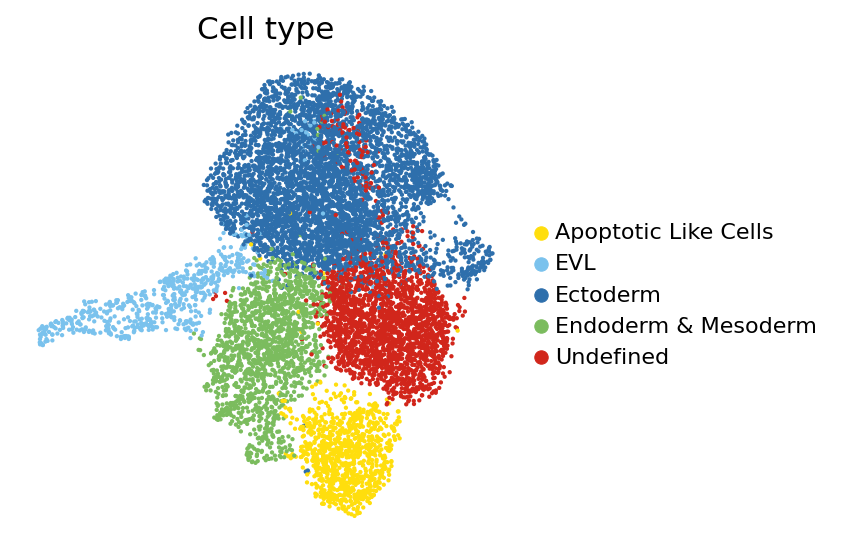

In [26]:
sc.set_figure_params(dpi=80, dpi_save=300,figsize=(4,4))
sc.pl.umap(adata,color=['cell_type'],legend_loc='right margin',legend_fontsize=10,legend_fontoutline=2,size=15,alpha=1,frameon=False,
           title="Cell type")

In [27]:
marker_genes_dict_3 = {
    'Ectoderm': ['blf','id1','sox11a'],
    'Apoptotic Like Cells': ['mdm2','sesn3','rps27l'],
    'PGC': ['buc','ccnb2','lsm14b'],
    'EVL': ['krt18a.1','krt4','stard14'],
    'Endoderm & Mesoderm': ['mixl1','wnt11f2','tbxta']}

categories: Apoptotic Like Cells, EVL, Ectoderm, etc.
var_group_labels: Ectoderm, Apoptotic Like Cells, PGC, etc.


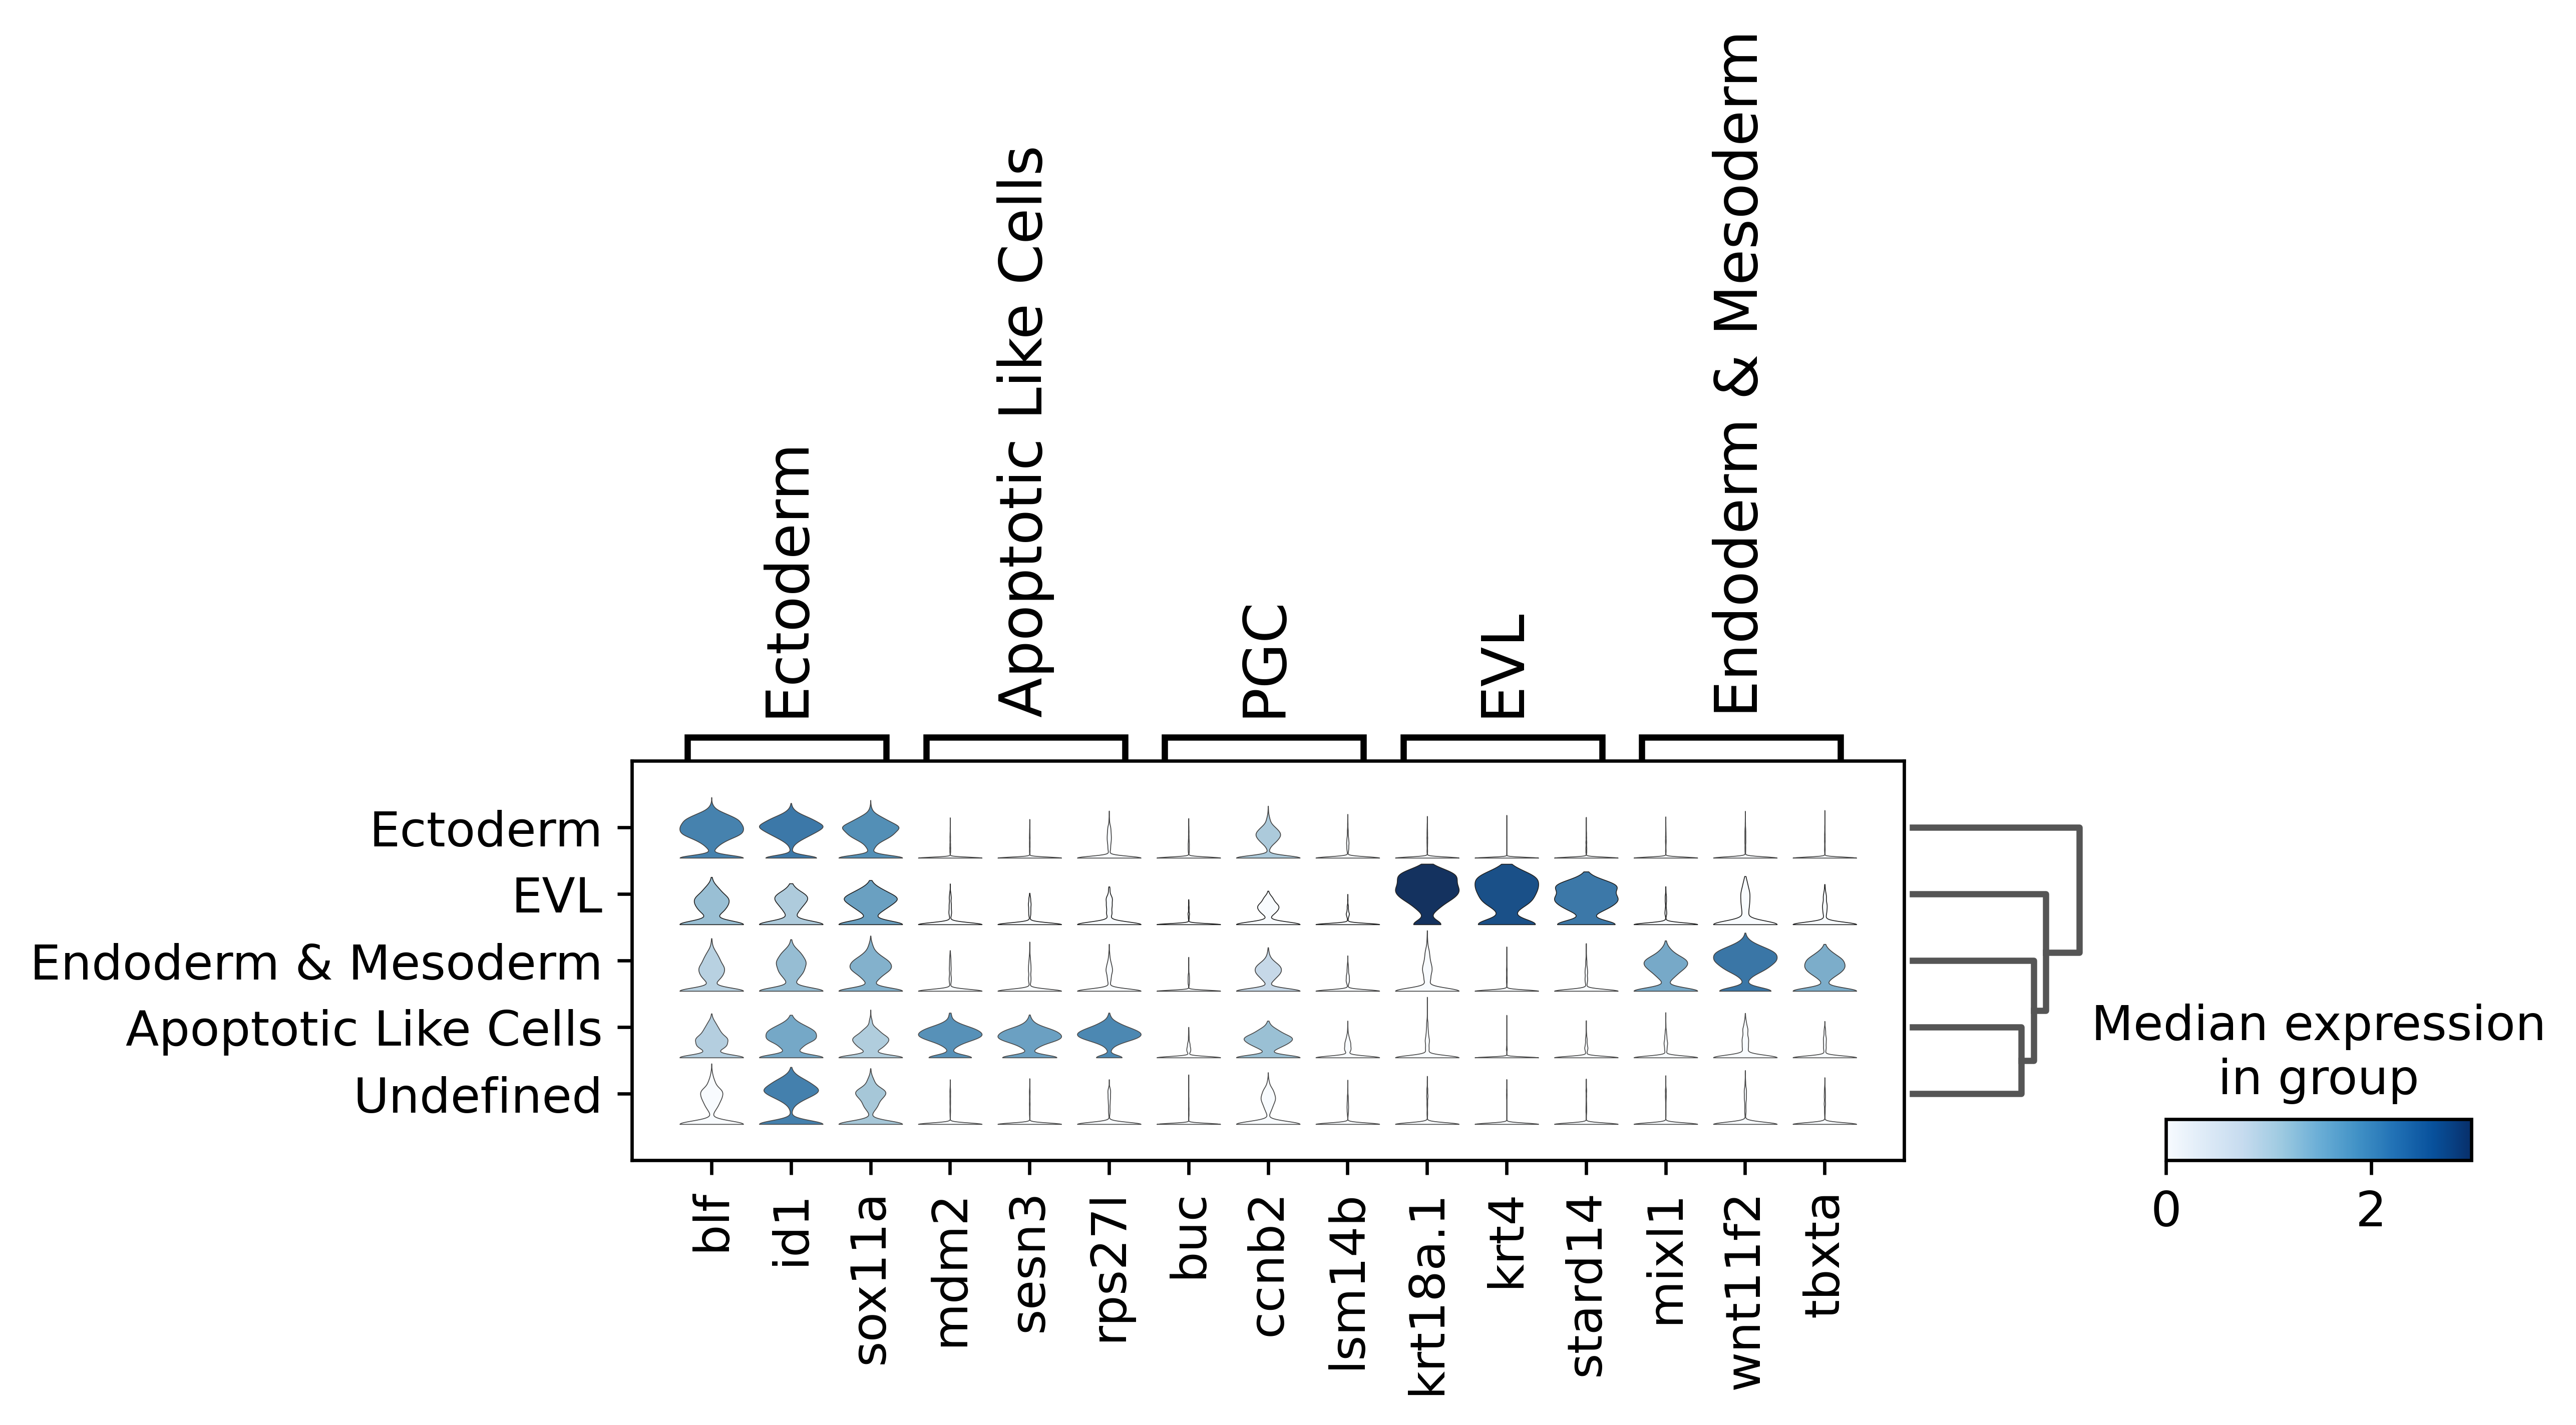

In [28]:
sc.set_figure_params(dpi=300, dpi_save=300,figsize=(10,2))
sc.pl.stacked_violin(
    adata, marker_genes_dict_3, groupby="cell_type", swap_axes=False, dendrogram=True,
)

# dynamo velocity

In [ ]:
adata_labeling = ad_all.copy()
adata_labeling.obs = adata.obs
adata_labeling
adata_dyn = ad.AnnData(X=adata_labeling.X, obs=adata_labeling.obs ,var=adata_labeling.var,layers=dict(
        new=adata_labeling.layers['X_l_TC'],old=adata_labeling.layers['X_n_TC'],
        total=adata_labeling.X))

In [ ]:
highly_variable_genes = adata.var_names[adata.var['highly_variable']]
highly_variable_genes_list = highly_variable_genes.tolist()

In [ ]:
adata_dyn.obsm['X_umap']=adata.obsm['X_umap']

In [ ]:
adata_dyn.obs['label_time'] = 4 # this is the labeling time
tkey = 'label_time'

In [ ]:
adata_conversion = adata_dyn[adata_dyn.obs['sample'].isin(['5.5hpf-mCPBApH5.2', '5.5hpf-mCPBApH7.4', '5.5hpf-IAA']), :]

In [29]:
def dynamo_workflow_label(adata_pro, **kwargs):
    
    preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True,gene_append_list = highly_variable_genes_list)
    preprocessor.config_monocle_recipe(adata_pro, n_top_genes=3000)
    preprocessor.preprocess_adata_monocle(
        adata_pro,
        tkey="label_time",
        experiment_type="one-shot", **kwargs
    )
    # dyn.tl.dynamics(adata_dyn, group="label_time", one_shot_method="sci_fate", model="deterministic")
    dyn.tl.dynamics(adata_pro,one_shot_method="sci_fate", model="stochastic",NTR_vel=True,re_smooth=True)
    #dyn.tl.dynamics(adata_pro,one_shot_method="sci_fate",model='deterministic',NTR_vel=True,re_smooth=True)

    dyn.tl.reduceDimension(adata_pro)
    
    dyn.tl.cell_velocities(adata_pro,calc_rnd_vel=True, transition_genes=adata_pro.var_names)

    dyn.vf.VectorField(adata_pro, basis='umap')

In [ ]:
dynamo_workflow_label(adata_conversion)

In [ ]:
dyn.export_h5ad(adata_conversion,'./Fig3_data/Fig3_Dropseq_adata_conversion_dynamo.h5ad')

In [39]:
adata_conversion = dyn.read_h5ad('./Fig3_data/Fig3_Dropseq_adata_conversion_dynamo.h5ad')

In [40]:
cell_type_color = ['#FFDE0D', '#7AC2ED', '#2E6FAC','#7BBC5E', '#D1261B','#D7D9DB']

In [41]:
adata_conversion

AnnData object with n_obs × n_vars = 7886 × 23484
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'batch', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'sample', 'leiden', 'res_.2', 'res_.4', 'res_.6', 'res_.8', 'res_1.', 'cell_type', 'label_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'labeled_est_Size_Factor', 'initial_labeled_est_cell_size', 'unlabeled_est_Size_Factor', 'initial_unlabeled_est_cell_size', 'old_Size_Factor', 'initial_old_cell_size', 'old_est_Size_Factor', 'initial_old_est_cell_size', 'unlabeled_Size_Factor', 'initial_unlabeled_cell_size', 'new_est_Size_Factor', 'initial_new_est_cell_size', 'total_layer_Size_Factor', 'initial_total_layer_cell_size', 'labeled_Size_Factor

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


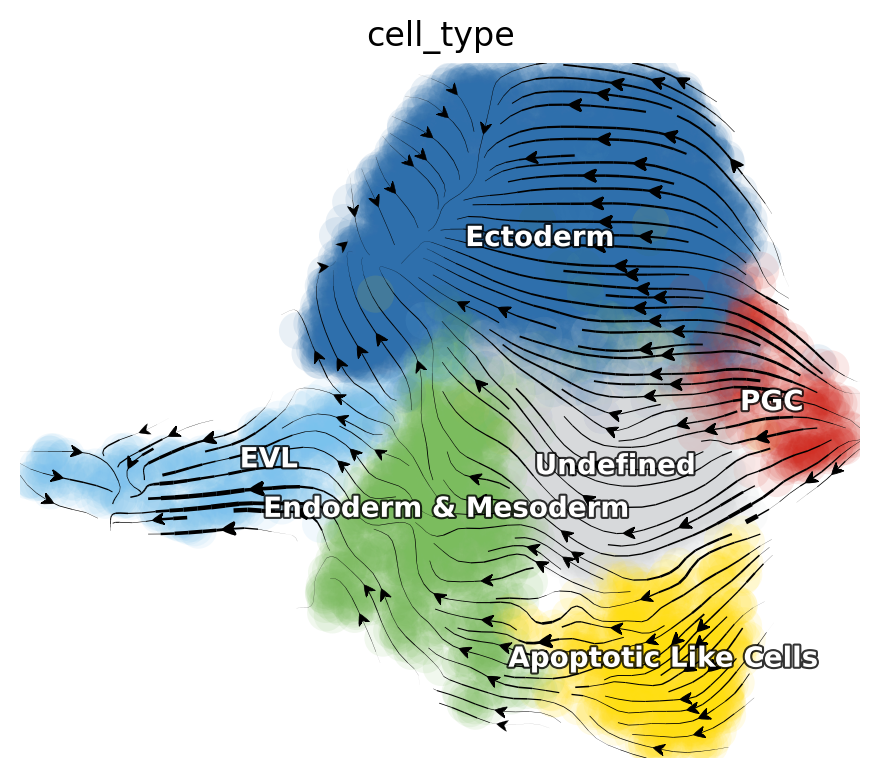

In [43]:
dyn.pl.streamline_plot(adata_conversion,color_key=cell_type_color,color=[ "cell_type"],basis="umap",figsize=[4.5,4])

# featrueplot

In [48]:
adata_plot = dyn.read_h5ad('./Fig3_data/Dropseq_all_adata_dynamo.h5ad')

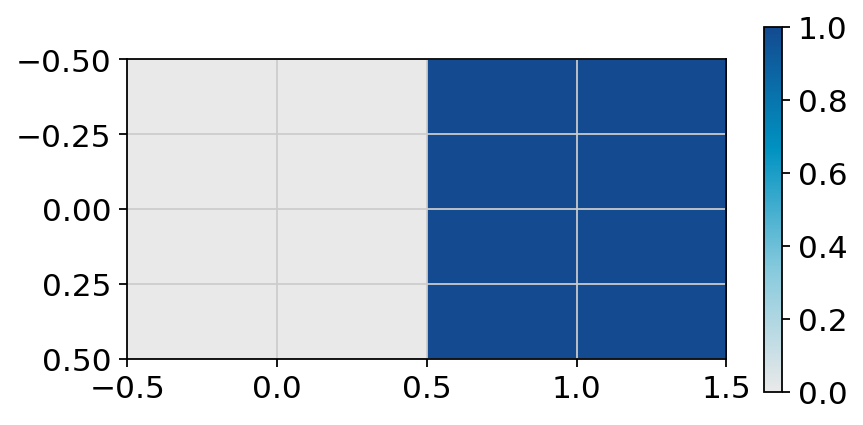

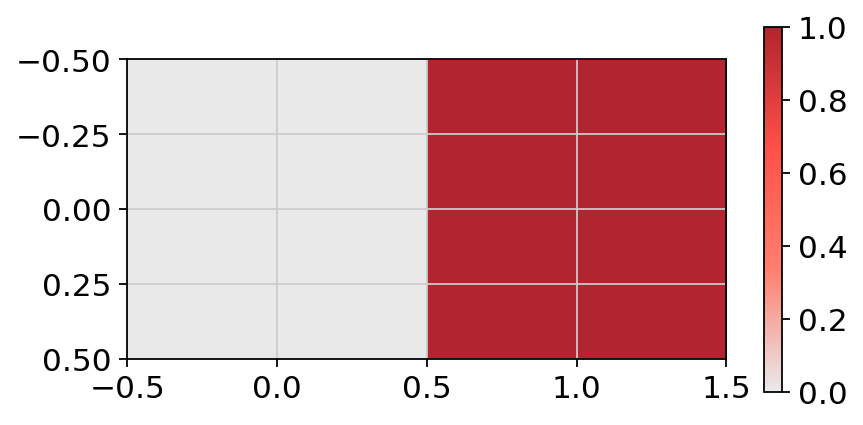

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
colors_blue = ['#E9E9E9','#87CADD', '#0092C1','#134A90']
# Create a colormap from the list of colors
blue_cmap_2 = LinearSegmentedColormap.from_list("custom_cmap", colors_blue)
# Test the colormap
plt.imshow([[0,1]], cmap=blue_cmap_2)
plt.colorbar()
plt.show()
colors_red = ['#E9E9E9', '#FF7F6F', '#FF5049', '#B22430']
# Create a colormap from the list of colors
red_cmap_2 = LinearSegmentedColormap.from_list("custom_cmap", colors_red)
# Test the colormap
plt.imshow([[0,1]], cmap=red_cmap_2)
plt.colorbar()
plt.show()

In [50]:
def get_featureplot_new_old(Anndata,gene_name,cmap_new,cmap_old):
    gene_index = np.where(Anndata.var_names == gene_name)[0][0]

    gene_data = Anndata.layers['X_total'][:, gene_index].data
    #gene_data = Anndata.layers['X_total'][:, gene_index].toarray().flatten()
    # The 30 % and 100 % quantiles of this gene data were calculated.
    vmin_values = np.percentile(gene_data, 30)
    vmax_values = np.percentile(gene_data, 100)
    #print(vmin_values,vmax_values)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(gene_name, fontsize=16)
#     sc.pl.umap(Anndata, color=[gene_name], cmap=cmap_featrue3, layer='X_total',vmin=vmin_values,vmax=vmax_values, size=50, frameon=False, ax=axs[0], show=False)
#     axs[0].set_title('total')
    sc.pl.umap(Anndata, color=[gene_name], cmap=cmap_new, layer='X_new', vmin=vmin_values,vmax=vmax_values, size=50, frameon=False, ax=axs[0], show=False)
    axs[0].set_title('new')
    sc.pl.umap(Anndata, color=[gene_name], cmap=cmap_old, layer='X_old',vmin=vmin_values,vmax=vmax_values, size=50, frameon=False, ax=axs[1], show=False)
    axs[1].set_title('old')
    plt.tight_layout()
#    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
    return fig

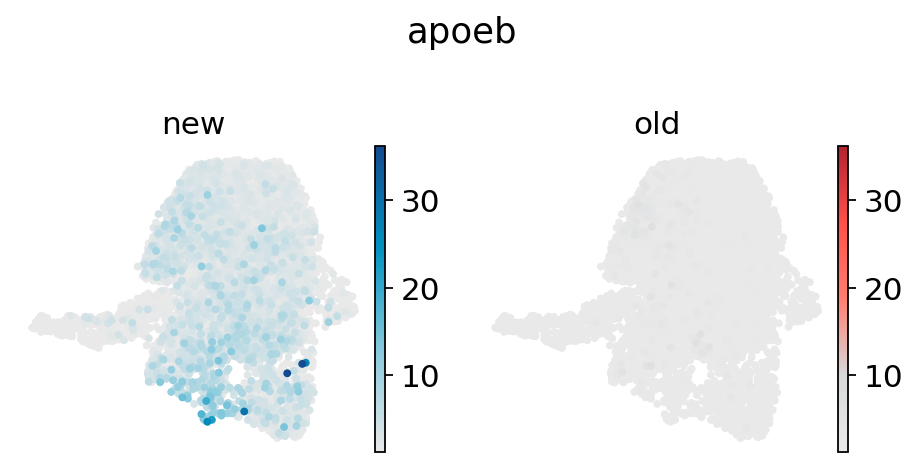

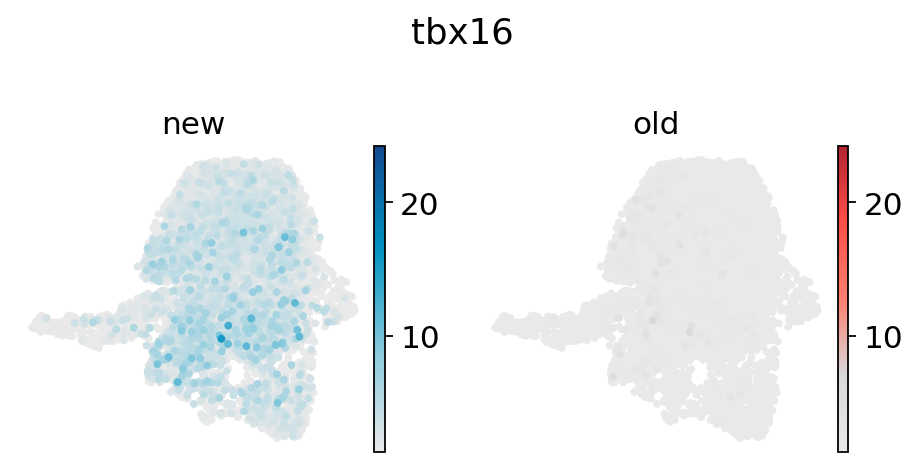

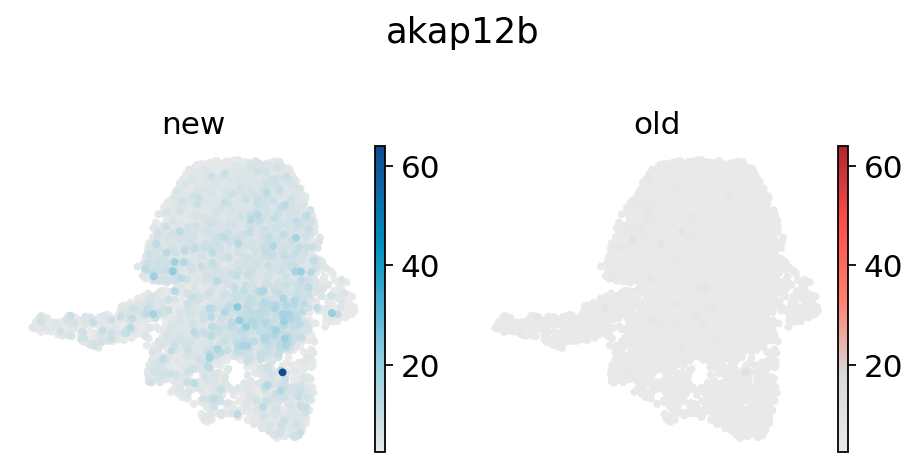

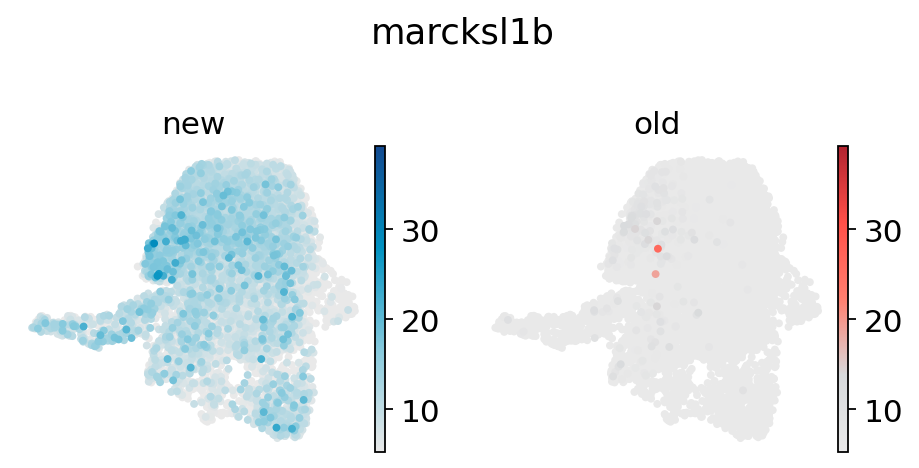

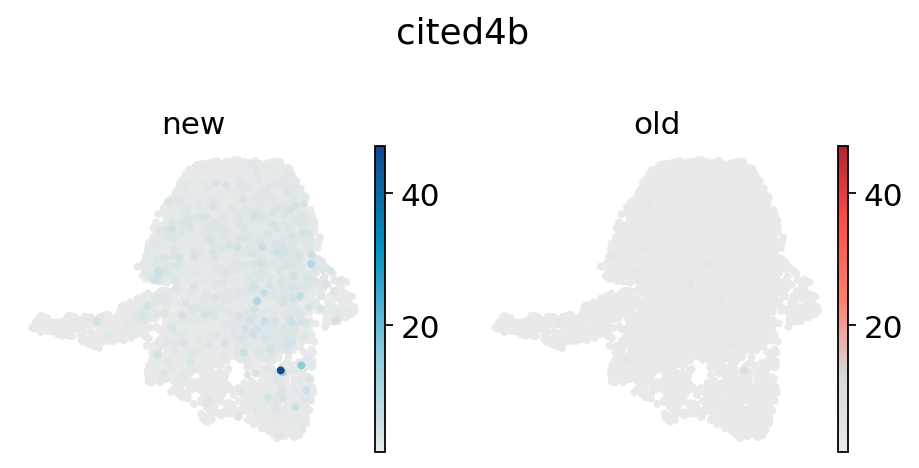

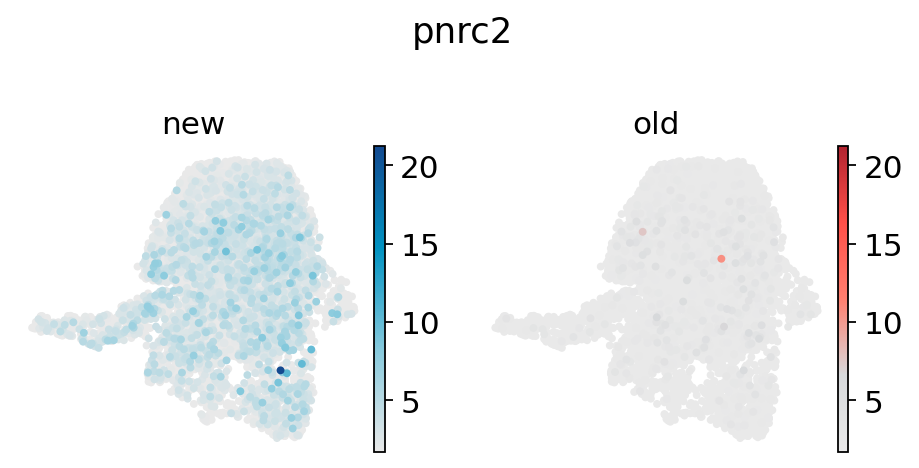

In [53]:
plt.rcParams['pdf.use14corefonts'] = True
sc.set_figure_params(dpi=80, dpi_save=300,figsize=(6,3))
for gene_name in ['apoeb', 'tbx16', 'akap12b','marcksl1b','cited4b','pnrc2']:
        fig = get_featureplot_new_old(adata_plot, gene_name,blue_cmap_2,red_cmap)
        plt.close(fig) 